In [1]:
import sys
sys.path.insert(0,'..')
import astropy
import astropy.units as u 
import astropy.constants as const

import os
import datetime

import numpy as np
import math
import scipy.optimize
import scipy.constants

import jabble.dataset
import jabble.loss
import jabble.model
import jabble.physics
import jabble.quickplay

import matplotlib.pyplot as plt

from collections import namedtuple
# from jaxopt import GaussNewton
import jax.numpy as jnp
import jax

jax.config.update("jax_enable_x64", True)

<h1>01 - Measure RVs from fake data using Wobble</h1>
In this notebook, we use wobble models to both create artificial data with given RVs. Then extract those RVs using the wobble Irwin-Hall model.

In [2]:
today = datetime.date.today()
out_dir = os.path.join('/scratch/mdd423/wobble_jax','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
def gaussian(x, mu, sigma):
    return np.exp(
        -((x - mu) ** 2) / (2 * sigma**2)
    )  # / (2 * sigma * np.sqrt(2 * np.pi))(1/np.sqrt(2 * np.pi *sigma**2)) * 

In [4]:
def create_dataset(x_grid, shifts, line, depth, snr, resolution):
    epoches = len(shifts)
    flux = np.ones((epoches, *x_grid.shape), dtype=np.float64)

    sigma = jabble.physics.delta_x(resolution)
    for i in range(epoches):
        flux[i, :] -= depth * gaussian(x_grid,line + shifts[i],sigma)

    # add noise
    flux += np.random.normal(0.0, np.abs(flux / snr),size=flux.shape)

    ferr = flux / snr
    yerr = ferr / flux
    mask = np.zeros(flux.shape)
    dataset = jabble.dataset.Data.from_lists(
        x_grid[None, :].repeat(epoches, 0), np.log(flux), 1/yerr**2, mask
    )
    return dataset

<h2>Fake Data Parameters</h2>
Here we define the parameters of the data, we will generate. This includes the resolution of the spectrograph, signal to noise ratio, number of epochs, and number of telluric and stellar spectral lines.

In [6]:
resolution = 120_000
snr = 350
epoches = 20

dx = jabble.physics.delta_x(2 * resolution)
lmin = 4654
lmax = 4657
x_grid = np.linspace(np.log(lmin), np.log(lmax), int((np.log(lmax) - np.log(lmin))/dx), \
                     dtype="float64")

wave_grid = np.exp(x_grid) * u.Angstrom

guess_vel = np.linspace(-60, 60, epoches) * u.km / u.s
extra_vel = np.linspace(-30, 30, epoches) * u.m / u.s
velocities = guess_vel + extra_vel
shifts = jabble.physics.shifts(velocities.to(u.m/u.s).value)

line = np.mean(x_grid)
depth = 0.7
dataset = create_dataset(x_grid, shifts, line, depth, snr, resolution)
print(x_grid.shape)

(154,)


Now generate multiple datasets with these parameters.

Let's take a look at a couple of epochs, before we go on modeling it.

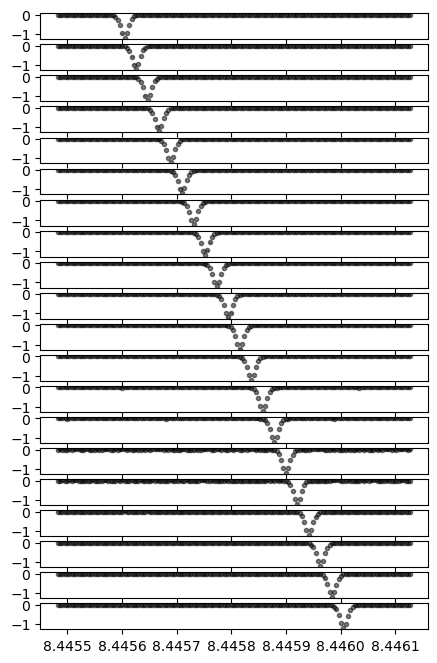

In [7]:
plt_epoches = np.arange(0,epoches,dtype=int)
fig, axes = plt.subplots(len(plt_epoches), figsize=(5, 8))
for i, plt_epoch in enumerate(plt_epoches):
    axes[i].errorbar(
        dataset[plt_epoch].xs[:],
        dataset[plt_epoch].ys[:],
        1/np.sqrt(dataset[plt_epoch].yivar[:]),
        fmt=".k",
        elinewidth=2.2,
        zorder=1,
        alpha=0.5,
        ms=6,
    )

    #     axes[ele].set_xlim(xpmin-shifts[ele],xpmax-shifts[ele])
    # axes[i].set_ylim(-2, 0.2)
plt.show()

In [8]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")

init_vels = guess_vel
init_shifts = jabble.physics.shifts(init_vels.to(u.m/u.s).value)

In [9]:
def get_model(dataset,resolution,p_val,vel_padding,init_rvs):
         
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    init_shifts = jabble.physics.shifts(init_rvs.to(u.m/u.s).value)
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts),#ShiftingModel(init_shifts),#
            jabble.model.FullCardinalSplineMixture(model_grid, p_val),
        ]
    ) 
    # + jabble.model.CompositeModel(
    #     [
    #         jabble.model.ShiftingModel(init_shifts),#ShiftingModel(init_shifts),#
    #         jabble.model.CardinalSplineMixture(model_grid, p_val),
    #     ]
    # )

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

In [10]:
def train_cycle(model, dataset, loss, device_store, device_op, batch_size):
    options = {"maxiter": 8,\
               "factr": 10.0,\
              }

    # Fit Stellar & Telluric Template
    model.fix()
    model.fit(1)
    model.display()
    
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0)
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)
    print(res1)

    # Fit Everything
    model.fix()
    model.fit(0)
    model.fit(1)
    # model.fit(2,1)

    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)

    return model

In [11]:
device_store = cpus[0]
device_op = cpus[0]
batch_size = 5000
p_val = 3
vel_padding = 100 * u.m/u.s

data_name = os.path.join(out_dir,'simple_fake','simple_fake_data_norm.pkl')
model_name = os.path.join(out_dir,'simple_fake','simple_fake_model_norm.pkl')

model =  get_model(dataset,resolution,p_val,vel_padding,guess_vel)

loss = jabble.loss.ChiSquare()

model.display()

model = train_cycle(model, dataset, loss, device_store, device_op, batch_size)

rv_model = model
for ii in [0]:
    rv_model = rv_model[ii]
rv_model.display()

jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0].p,\
                      device=device_op,loss=loss,rv_ind=[0])

-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-FullCardinalSplineMixture--------------------------------------0
-CompositeModel--------------------------------------------------155
  0-ShiftingModel--------------------------------------------------0
  1-FullCardinalSplineMixture------------------------------------155


TypeError: dot_general requires contracting dimensions to have the same shape, got (155,) and (154,).

In [ ]:
def make_subplot(axes,model,dataset,plt_epoch,device,lrange):

    model.fix()
    data, meta, keys = dataset.blockify(device,return_keys=True)
    
    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)

    axes[0].set_xlim(xplot.min(),xplot.max())

    
    # Data
    # print(datarow)
    axes[0].errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]],\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=5)

    # Stellar Model        
    axes[0].plot(xplot,yplot_norm_tot,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    
    # Residuals
    axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
                             'k',where='mid',zorder=1,alpha=0.3,ms=3)

    

    axes[1].set_ylim(-1,1)
    
    # axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticks(np.log(lrange))

    axes[0].set_xticklabels(['' for x in lrange])
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(8,4),sharex='col',sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,1],dpi=200)


# plt_width = np.arange(-40,40,20) + 10
plt_epoch = 19

lrange = np.linspace(np.min(np.exp(dataset[plt_epoch].xs))-1,\
                     np.max(np.exp(dataset[plt_epoch].xs))+2,4)[:,None]

# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 


plt_name = "{}_spectra_l{}-{}.png".format('simple_fake',lrange.min(),lrange.max())
# axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
axes[:] = make_subplot(axes[:],model,dataset,plt_epoch,cpus[0],lrange[:,0])
fig.text(0.5, 0.04, 'Wavelength [$\\AA$]', ha='center')
plt.show()

In [ ]:
def fischer_full(model, data, device):
    """
    Get fischer information on parameters of the model.
    Since each parameter is independent of all other epochs, fischer information matrix is diagonal,
    thus returns this diagonal.

    Parameters
    ----------
    model : `jabble.Model`
        The full model to evaluate.
    data : `jabble.Dataset`
        Data to be evaluate.

    Returns
    -------
    f_info : 'jnp.array`
        (N,) array of diagonal of fischer information matrix.
    """
    model.fit()
    model.display()

    datablock, metablock = data.blockify(device)
    # def _internal(self, p, datarow, metarow, model, *args)
    #     return loss(self, p, datarow, metarow, model, *args)
    dfdt = jax.jacfwd(model, argnums=0)

    def get_dict(datablock, index):
        return {key: datablock[key][index] for key in datablock.keys()}

    curvature_all = np.zeros((len(data),datablock['xs'].shape[1], len(model.get_parameters())))

    for i in range(len(data)):
        datarow = get_dict(datablock, i)
        metarow = get_dict(metablock, i)
        curvature_all[i,:,:] = jnp.where(~datarow["mask"][:, None]*\
                                  np.ones(len(model.get_parameters()))[None, :],
            (dfdt(model.get_parameters(), datarow["xs"], metarow)),
            0.0
        )

    f_info = np.zeros((len(model.get_parameters()),len(model.get_parameters())))
    for i in range(len(data)):
        datarow = get_dict(datablock, i)
        metarow = get_dict(metablock, i)
        
        f_info += np.einsum('j,jn,jm->nm',datarow['yivar'][:],curvature_all[i,:,:],\
                     curvature_all[i,:,:])

    return f_info

# model that have submodels can be defined by nested lists, split_p will split a length A+N array into A and N
# where A and N are the length of the parameters, theta of submodels. If a submodel is container of containers 
# like fs(g(x|theta_a)|theta_n) + ft(g(x|theta_b)|theta_m)
# then split_p only drops one layer down, (A+N,B+M)
# thus split (A+N) -> A,N
def tree_sum(model,p_list,reduce_index):
    sum_list = []
    for i,(ele,submodel) in enumerate(zip(p_list,model.models)):
        if isinstance(submodel, jabble.model.ContainerModel) and i == reduce_index[0]:
            new_list, mark_temp = tree_sum(submodel,submodel.split_p(ele),reduce_index[1:])
            mark_ele = mark_temp + i
            sum_list += new_list
        else:
            if i == reduce_index[0]:
                mark_ele = i
            sum_list.append(len(ele))
    return sum_list, mark_ele



def reduce_fischer(model,f_info,reduce_index):
    # NOW REDUCE
    p_list = model.split_p(model.get_parameters())
    sum_list, mark_ele = tree_sum(model,p_list,reduce_index)

    print(sum_list,mark_ele)
    print('a',0,int(np.sum(sum_list[:mark_ele])),int(np.sum(sum_list[:mark_ele+1])),0,\
          '\nn',int(np.sum(sum_list[:mark_ele])),int(np.sum(sum_list[:mark_ele+1])))

    faa_info_uu = f_info[0:int(np.sum(sum_list[:mark_ele])),0:int(np.sum(sum_list[:mark_ele]))]
    faa_info_ub = f_info[0:int(np.sum(sum_list[:mark_ele])),int(np.sum(sum_list[:mark_ele+1])):-1]
    faa_info_bb = f_info[int(np.sum(sum_list[:mark_ele+1])):-1,int(np.sum(sum_list[:mark_ele+1])):-1]
    faa_info_bu = f_info[int(np.sum(sum_list[:mark_ele+1])):-1,0:int(np.sum(sum_list[:mark_ele]))]

    faa_info = np.block([[faa_info_uu,faa_info_ub],[faa_info_bu,faa_info_bb]])

    fnn_info = f_info[int(np.sum(sum_list[:mark_ele])):int(np.sum(sum_list[:mark_ele+1])),\
                      int(np.sum(sum_list[:mark_ele])):int(np.sum(sum_list[:mark_ele+1]))]

    fan_info_l = f_info[int(np.sum(sum_list[:mark_ele])):int(np.sum(sum_list[:mark_ele+1])),\
                        0:int(np.sum(sum_list[:mark_ele]))]
    fan_info_r = f_info[int(np.sum(sum_list[:mark_ele])):int(np.sum(sum_list[:mark_ele+1])),\
                        int(np.sum(sum_list[:mark_ele+1])):-1]
    
    fan_info = np.concatenate([fan_info_l,fan_info_r],axis=1)

    fna_info_t = f_info[0:int(np.sum(sum_list[:mark_ele])),\
                        int(np.sum(sum_list[:mark_ele])):int(np.sum(sum_list[:mark_ele+1]))]
    fna_info_b = f_info[int(np.sum(sum_list[:mark_ele+1])):-1,\
                        int(np.sum(sum_list[:mark_ele])):int(np.sum(sum_list[:mark_ele+1]))]
    
    fna_info = np.concatenate([fna_info_t,fna_info_b],axis=0)

    print(fna_info.shape,fan_info.shape,faa_info.shape,fnn_info.shape)
    return fnn_info - (fan_info @ np.linalg.inv(faa_info) @ fna_info)

def backwards_pass(model,xp,xq,f_info):
    dtdf = jax.jacfwd(model.reverse, argnums=0)
    return dtdf(model.get_parameters(),xp,metarow) @ f_info @ dtdf(model.get_parameters(),xp,metarow).transpose()

f_info = fischer_full(model, dataset, cpus[0])
reduce_index = [1]
reduce_info = reduce_fischer(model,f_info,reduce_index)


snr = backwards_pass(model[1],x_grid,x_grid,reduce_info)

In [ ]:
reduce_info.shape

In [ ]:
plt.imshow(reduce_info,vmin=0,vmax=1e8)
plt.show()

In [ ]:
f_info[20:,20:]